### Задание 10

У нас есть такая система:

\begin{cases}
    y''(x) = a^2y(x) \\
    y(0) = 1 \\
    y'(0) = -a
\end{cases}


Невооруженным взглядом видно, что единственное решение такой системы -- $y = e^{-ax}$

Заменой $y_0 := y$ и $y_1 := y'$ сделаем из неё систему первого порядка:


\begin{cases}
    y_1'(x) = a^2y_0(x) \\
    y_0'(x) = y_1(x) \\
    y_0(0) = 1 \\
    y_1(0) = -a
\end{cases}

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

def draw_plot(rang, *funcs, xlog=False, ylog=False, legend=None):
    xs = []
    ys = []
    for _ in funcs:
        ys.append([])
    
    for x in rang:
        xs.append(x)
        for i, f in enumerate(funcs):
            ys[i].append(f(x))
    
    for i, y in enumerate(ys):
        plt.plot(xs, y, label=None if legend is None else legend[i])
    
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')
    if legend:
        plt.legend()
    
    plt.show()
    
def list_func(l):
    return lambda n: l[n]

Реализуем метод Эйлера:

In [2]:
def euler_method(N, FROM, TO, from_ys, fy_s):
    FROM = np.float64(FROM)
    TO = np.float64(TO)
    
    assert TO > FROM
    assert N > 0
    assert len(from_ys) == len(fy_s)
    
    h = (TO - FROM) / np.float64(N)
    ln = len(from_ys)
    
    ys = [list(map(lambda x: np.float64(x), from_ys))]
    y_s = [[fy_s[i](FROM, ys[-1]) for i in range(ln)]]
    
    for i in range(N):        
        ys.append([ys[-1][i] + h * fy_s[i](FROM + h * np.float64(i), ys[-1]) for i in range(ln)])
        y_s.append([fy_s[i](FROM + h * np.float64(i + 1), ys[-1]) for i in range(ln)])
    
    return [[ys[j][i] for j in range(N + 1)] for i in range(ln)]

In [10]:
def draw_exp_approximation(N, A, T):
    from_ys = [1, -A]
    fy_s = [lambda _, ys: ys[1], lambda _, ys: A**2 * ys[0]]
    result = euler_method(N, 0, T, from_ys, fy_s)[0]
    draw_plot(range(N + 1), list_func(result))

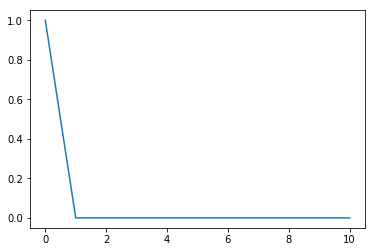

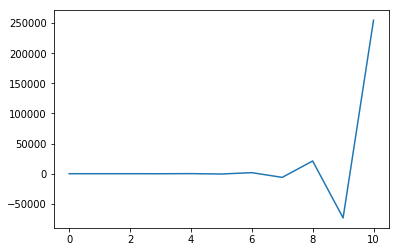

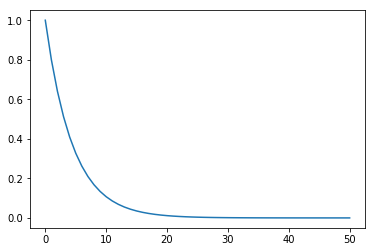

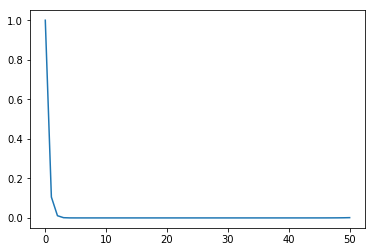

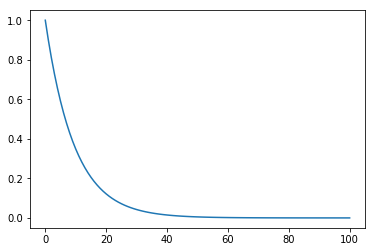

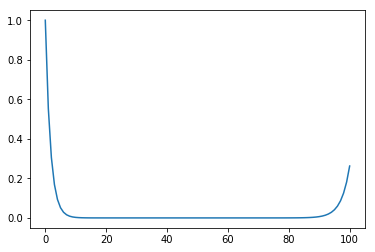

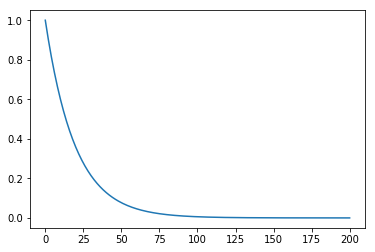

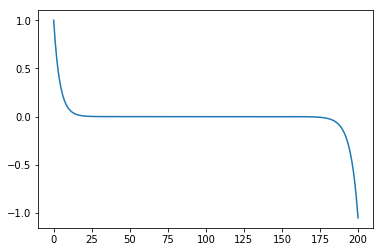

In [11]:
draw_exp_approximation(10, 1, 10)
draw_exp_approximation(10, math.sqrt(20), 10)
draw_exp_approximation(50, 1, 10)
draw_exp_approximation(50, math.sqrt(20), 10)
draw_exp_approximation(100, 1, 10)
draw_exp_approximation(100, math.sqrt(20), 10)
draw_exp_approximation(200, 1, 10)
draw_exp_approximation(200, math.sqrt(20), 10)

Мораль, видимо, такая: при маленьких $n$ мы делаем довольно большие шаги и в местах "изгиба" функции нас из-за этого может начать "раскачивать" из стороны в сторону в попытках выровняться обратно. В нашем конкретном случае так происходит поскольку мы начинаем со значений разных знаков, а наша система является двухшаговой. Из-за длинных шагов мы создаём ошибку, а регулярным домножением на 20 экспоненциально её накапливаем, чего не происходит с в случае с $a = 1$.

При больших $n$ всё сначала идёт хорошо, но под конец из-за довольно малых значений, экспоненциально приближающихся к 0, и итеративности процесса какие-нибуль две подряд идущие ошибки вычисления в одну сторону могут отклонить нас от изначальной траектории и завернуть график в сторону ошибки. Если это случилось, это случается тем медленнее, чем больше N, посколько h замедляет скорость этого роста. Для сильно близких к нулю значений погрешность довольно высока (уже начиная с $10^{-18}$ всё довольно печально, бит не хватает под сильно маленькие числа). В итоге домножение на 20 в конце концов перебивает теоретическую экспоненту и уводит график в сторону погрешности.

Посчитаем разность с аналитическим решением.

In [28]:
def get_max_diff(rng, f1, f2):
    max_diff = 0.
    for i in rng:
        max_diff = max(max_diff, abs(f1[i] - f2[i]))
    return max_diff

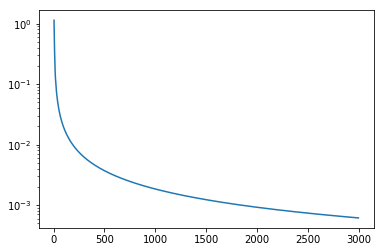

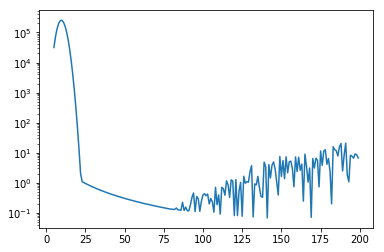

In [30]:
f1 = lambda x: math.exp(-x)
f2 = lambda x: math.exp(-math.sqrt(20) * x)

T = np.float64(10)


draw_plot(range(5, 3000), lambda n: get_max_diff(range(n + 1),
                                              euler_method(n, 0, T, [1, -1], [lambda _, ys: ys[1], lambda _, ys: ys[0]])[0],
                                              [f1(np.float64(i) * T / n) for i in range(n + 1)])
         
         , ylog=True)

draw_plot(range(5, 200), lambda n: get_max_diff(range(n + 1),
                                              euler_method(n, 0, T, [1, -math.sqrt(20)], [lambda _, ys: ys[1], lambda _, ys: 20. * ys[0]])[0],
                                              [f2(np.float64(i) * T / n) for i in range(n + 1)])
         
         , ylog=True)

В первом графике очень хорошее a. Оно совсем никак не влияет на рост функции, поэтому со временем единственное, что происходит -- это с увеличеснием количества кусочков закономерно растёт точность. 

Во втором случае, $a = \sqrt{20}$ и это даёт нам много проблем. В какой-то момент, как я уже говорила, функция просто уходит в неверном направлении рождая большую максимальную погрешность. Как мы видим по графику, максимальная ошибка убывает вплоть до ~ 85, после чего случается нечто шумное (как раз похоже на скачки погрещностей). Видимо, до значения 85 она не успевает накопиться, после чего постепенно набирает обороты.

Реализуем метод Рунге-Кутта второго порядка.

In [ ]:
def runge_method(N, T, A, beta=0.5):
    A = np.float64(A)
    T = np.float64(T)
    
    h = T / np.float64(N)
    
    ys1 = [np.float64(1)]
    ys2 = [-A]
    y_s1 = [-A]
    y_s2 = [A**2]
    
    for i in range(N):        
         ys2.append(ys2[-1] + h * ((1. - beta) * A**2 * y_s1[-1]) + beta * )
        y_s.append()